# 1

In [ ]:
pip install opencv-python numpy pandas scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_path = '/content/drive/MyDrive/PCD 2025/datasetPCD/Original Images/Original Images'
folders = os.listdir(base_path)

print("Isi folder MyDrive:")
for item in folders:
    item_path = os.path.join(base_path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}")
    else:
        print(f"📄 {item}")

Isi folder MyDrive:
📁 Zac Efron
📁 Marmik
📁 Robert Downey Jr
📁 Tom Cruise
📁 Virat Kohli
📁 Natalie Portman
📁 Roger Federer
📁 Priyanka Chopra
📁 Vijay Deverakonda
📁 Margot Robbie
📁 Lisa Kudrow
📁 Hugh Jackman
📁 Elizabeth Olsen
📁 Courtney Cox
📁 Jessica Alba
📁 Hrithik Roshan
📁 Dwayne Johnson
📁 Kashyap
📁 Ellen Degeneres
📁 Henry Cavill
📁 Claire Holt
📁 Camila Cabello
📁 Alia Bhatt
📁 Amitabh Bachchan
📁 Charlize Theron
📁 Andy Samberg
📁 Billie Eilish
📁 Alexandra Daddario
📁 Anushka Sharma
📁 Brad Pitt
📁 Akshay Kumar


# **1. EDA**


1. Memahami Struktur Data
Kami memuat dan menampilkan informasi dasar tentang dataset, seperti jumlah data dan contoh data pertama. Dataset ini terdiri dari gambar wajah dengan label individu yang berbeda.

2. Distribusi Label
Kami menganalisis distribusi label untuk melihat apakah terdapat ketidakseimbangan kelas. Beberapa individu memiliki lebih banyak gambar dibandingkan yang lain, yang dapat mempengaruhi akurasi model. Misalnya, Brad Pitt memiliki proporsi data terbesar (4.68%), sedangkan beberapa individu seperti Marmik dan Kashyap memiliki jumlah gambar yang sangat sedikit.

3. Pemeriksaan Kualitas Data
Kami memeriksa apakah ada gambar yang hilang atau tidak dapat ditemukan dalam dataset.

4. Visualisasi Sampel Gambar
Sebagai bagian dari pemeriksaan kualitas, kami menampilkan sampel gambar untuk memastikan bahwa gambar dalam dataset memiliki kualitas yang baik dan konsisten, serta sesuai untuk model pengenalan wajah.

5. Identifikasi Potensi Masalah
Melalui analisis ini, kami dapat mengidentifikasi potensi masalah seperti ketidakseimbangan kelas, gambar yang hilang, dan variasi kualitas gambar, yang perlu diatasi sebelum melanjutkan ke tahap preprocessing dan modeling.

EXPLORATORY DATA ANALYSIS - FACE RECOGNITION DATASET

1. INFORMASI DASAR DATASET
----------------------------------------
✓ Dataset berhasil dimuat
✓ Jumlah total sampel: 2562
✓ Jumlah kolom: 2
✓ Kolom yang tersedia: ['id', 'label']

Contoh 5 data pertama:
                        id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2562 non-null   object
 1   label   2562 non-null   object
dtypes: object(2)
memory usage: 40.2+ KB
None


2. ANALISIS DISTRIBUSI LABEL
----------------------------------------
✓ Jumlah kelas/individu unik: 31
✓ Total sampel per kelas:
   - Akshay Kumar: 50 gambar
  

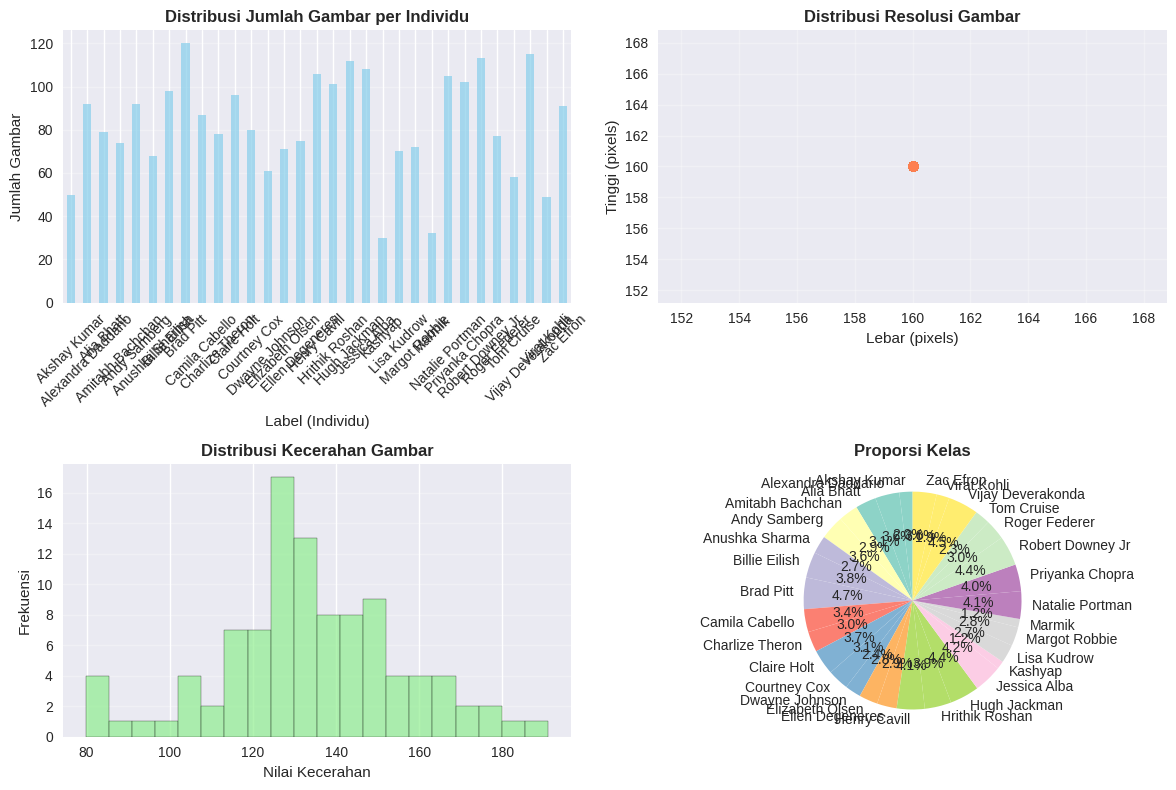


8. CONTOH GAMBAR DARI DATASET
----------------------------------------


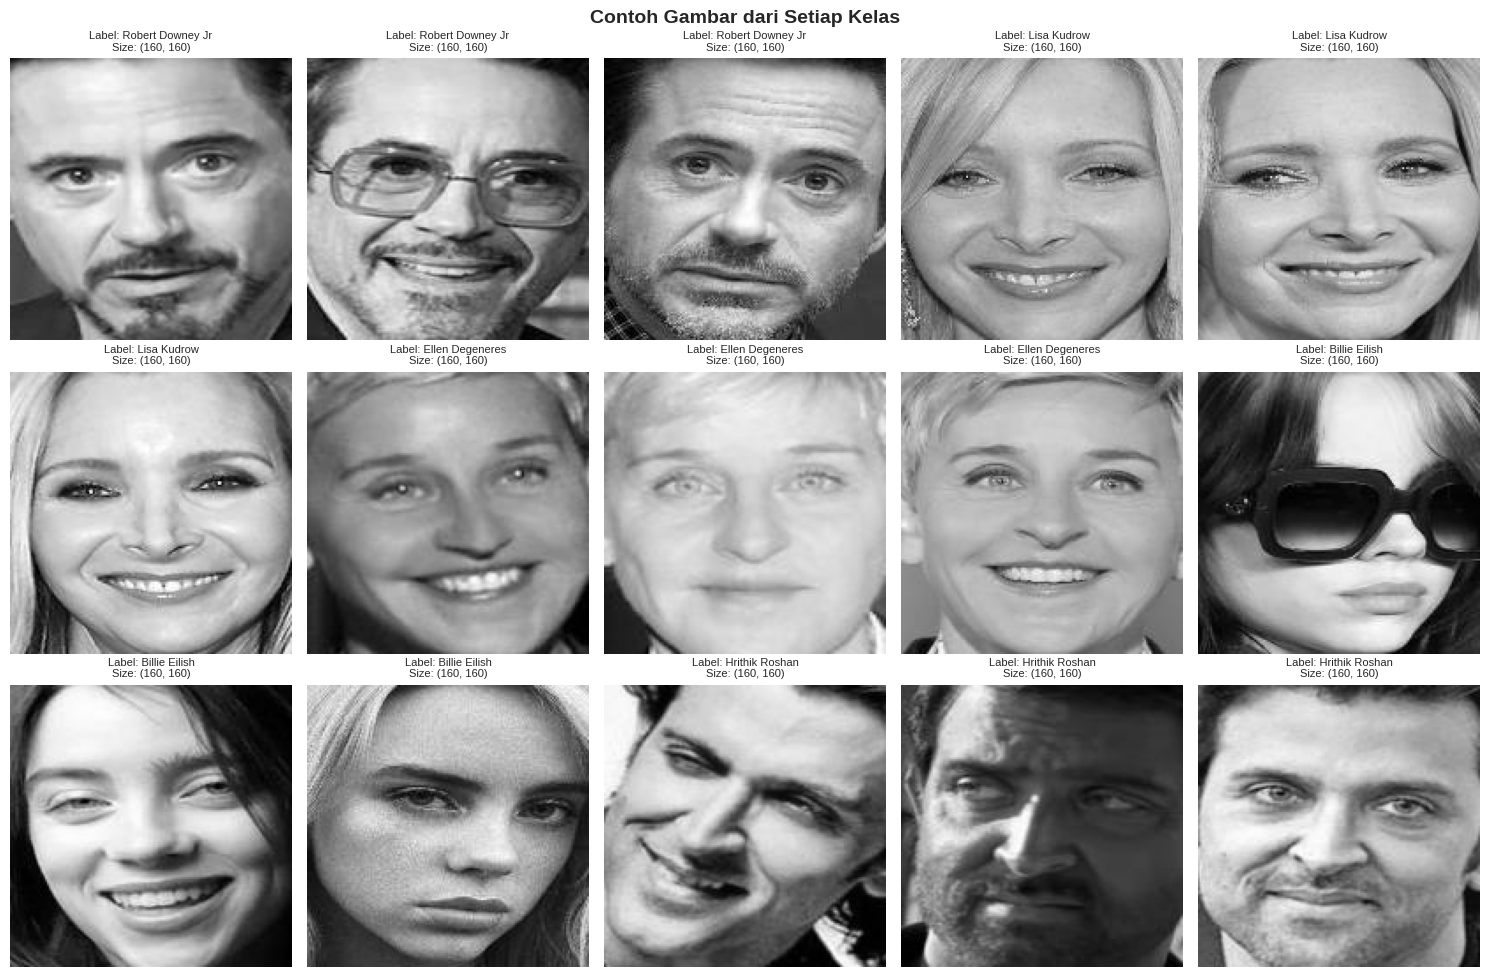



9. RINGKASAN & REKOMENDASI
📊 RINGKASAN DATASET:
   • Total sampel: 2562
   • Jumlah kelas: 31
   • Gambar valid: 2562
   • Gambar bermasalah: 0

🎯 REKOMENDASI PREPROCESSING:
   • Standardisasi resolusi gambar (misal: 128x128 atau 224x224)
   • Normalisasi intensitas pixel (0-1 atau -1 sampai 1)
   • Pertimbangkan data augmentation untuk kelas minoritas
   • Filter atau hapus gambar yang terlalu blur

🔧 LANGKAH SELANJUTNYA:
   1. Preprocessing dan augmentasi data
   2. Split dataset (train/validation/test)
   3. Pilih arsitektur model (CNN, pre-trained model)
   4. Training dengan cross-validation
   5. Evaluasi performa model

✅ EDA SELESAI!


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import seaborn as sns

# Set style untuk visualisasi yang lebih baik
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Path dataset
csv_path = '/content/drive/MyDrive/PCD 2025/datasetPCD/Dataset.csv'
img_folder = '/content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces'

print("="*60)
print("EXPLORATORY DATA ANALYSIS - FACE RECOGNITION DATASET")
print("="*60)

# 1. BASIC DATASET INFORMATION
print("\n1. INFORMASI DASAR DATASET")
print("-"*40)
try:
    df = pd.read_csv(csv_path)
    print(f"✓ Dataset berhasil dimuat")
    print(f"✓ Jumlah total sampel: {len(df)}")
    print(f"✓ Jumlah kolom: {len(df.columns)}")
    print(f"✓ Kolom yang tersedia: {list(df.columns)}")

    print(f"\nContoh 5 data pertama:")
    print(df.head())

    print(f"\nInfo dataset:")
    print(df.info())

except Exception as e:
    print(f"✗ Error membaca dataset: {e}")
    exit()

# 2. ANALISIS DISTRIBUSI LABEL
print("\n\n2. ANALISIS DISTRIBUSI LABEL")
print("-"*40)
label_counts = df['label'].value_counts().sort_index()
unique_labels = df['label'].nunique()

print(f"✓ Jumlah kelas/individu unik: {unique_labels}")
print(f"✓ Total sampel per kelas:")
for label, count in label_counts.items():
    print(f"   - {label}: {count} gambar")

# Statistik distribusi
print(f"\nStatistik distribusi:")
print(f"   - Rata-rata sampel per kelas: {label_counts.mean():.2f}")
print(f"   - Median sampel per kelas: {label_counts.median():.2f}")
print(f"   - Std deviasi: {label_counts.std():.2f}")
print(f"   - Min sampel: {label_counts.min()}")
print(f"   - Max sampel: {label_counts.max()}")

# 3. CEK KEBERADAAN FILE GAMBAR
print("\n\n3. VALIDASI KEBERADAAN FILE GAMBAR")
print("-"*40)
missing_images = []
existing_images = []
corrupted_images = []

for idx, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])

    if not os.path.exists(image_path):
        missing_images.append((idx, row['id'], row['label']))
    else:
        # Cek apakah gambar bisa dibaca
        try:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                corrupted_images.append((idx, row['id'], row['label']))
            else:
                existing_images.append((idx, row['id'], row['label']))
        except:
            corrupted_images.append((idx, row['id'], row['label']))

print(f"✓ Gambar yang tersedia: {len(existing_images)}")
print(f"✗ Gambar yang hilang: {len(missing_images)}")
print(f"✗ Gambar yang corrupt: {len(corrupted_images)}")

if missing_images:
    print(f"\nContoh gambar yang hilang:")
    for i, (idx, img_id, label) in enumerate(missing_images[:5]):
        print(f"   - Index {idx}: {img_id} (Label: {label})")

# 4. ANALISIS RESOLUSI GAMBAR
print("\n\n4. ANALISIS RESOLUSI GAMBAR")
print("-"*40)
resolutions = []
file_sizes = []

for idx, img_id, label in existing_images:
    image_path = os.path.join(img_folder, img_id)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resolutions.append(img.shape)
    file_sizes.append(os.path.getsize(image_path))

if resolutions:
    unique_resolutions = list(set(resolutions))
    print(f"✓ Resolusi unik yang ditemukan: {len(unique_resolutions)}")

    resolution_counts = Counter(resolutions)
    print(f"✓ Distribusi resolusi:")
    for res, count in sorted(resolution_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"   - {res[1]}x{res[0]}: {count} gambar ({count/len(resolutions)*100:.1f}%)")

    # Statistik resolusi
    heights = [res[0] for res in resolutions]
    widths = [res[1] for res in resolutions]

    print(f"\nStatistik resolusi:")
    print(f"   - Tinggi: min={min(heights)}, max={max(heights)}, rata-rata={np.mean(heights):.1f}")
    print(f"   - Lebar: min={min(widths)}, max={max(widths)}, rata-rata={np.mean(widths):.1f}")

# 5. ANALISIS KUALITAS GAMBAR
print("\n\n5. ANALISIS KUALITAS GAMBAR")
print("-"*40)
brightness_stats = []
contrast_stats = []
blur_stats = []

sample_size = min(100, len(existing_images))  # Analisis sample untuk efisiensi
print(f"Menganalisis kualitas dari {sample_size} gambar sample...")

for i in range(sample_size):
    idx, img_id, label = existing_images[i]
    image_path = os.path.join(img_folder, img_id)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Brightness (rata-rata intensitas pixel)
    brightness = np.mean(img)
    brightness_stats.append(brightness)

    # Contrast (standar deviasi intensitas pixel)
    contrast = np.std(img)
    contrast_stats.append(contrast)

    # Blur detection (varian Laplacian)
    blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
    blur_stats.append(blur_score)

if brightness_stats:
    print(f"✓ Statistik Kecerahan:")
    print(f"   - Rata-rata: {np.mean(brightness_stats):.1f}")
    print(f"   - Min: {np.min(brightness_stats):.1f}, Max: {np.max(brightness_stats):.1f}")

    print(f"✓ Statistik Kontras:")
    print(f"   - Rata-rata: {np.mean(contrast_stats):.1f}")
    print(f"   - Min: {np.min(contrast_stats):.1f}, Max: {np.max(contrast_stats):.1f}")

    print(f"✓ Statistik Blur (semakin tinggi = semakin tajam):")
    print(f"   - Rata-rata: {np.mean(blur_stats):.1f}")
    print(f"   - Min: {np.min(blur_stats):.1f}, Max: {np.max(blur_stats):.1f}")

    # Identifikasi gambar bermasalah
    very_dark = sum(1 for b in brightness_stats if b < 50)
    very_bright = sum(1 for b in brightness_stats if b > 200)
    low_contrast = sum(1 for c in contrast_stats if c < 20)
    very_blurry = sum(1 for bl in blur_stats if bl < 100)

    print(f"\n⚠️  Potensi masalah kualitas:")
    print(f"   - Gambar terlalu gelap (< 50): {very_dark}")
    print(f"   - Gambar terlalu terang (> 200): {very_bright}")
    print(f"   - Kontras rendah (< 20): {low_contrast}")
    print(f"   - Gambar blur (< 100): {very_blurry}")

# 6. ANALISIS CLASS IMBALANCE
print("\n\n6. ANALISIS KESEIMBANGAN KELAS")
print("-"*40)
class_proportions = df['label'].value_counts(normalize=True).sort_index()

print(f"✓ Proporsi setiap kelas:")
for label, prop in class_proportions.items():
    print(f"   - {label}: {prop:.3f} ({prop*100:.1f}%)")

# Hitung imbalance ratio
max_samples = label_counts.max()
min_samples = label_counts.min()
imbalance_ratio = max_samples / min_samples

print(f"\n✓ Analisis keseimbangan:")
print(f"   - Rasio ketidakseimbangan: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print(f"   ⚠️  Dataset tidak seimbang - pertimbangkan teknik balancing")
else:
    print(f"   ✓ Dataset relatif seimbang")

# 7. VISUALISASI
print("\n\n7. MEMBUAT VISUALISASI")
print("-"*40)

# Visualisasi 1: Distribusi Label
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
label_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title("Distribusi Jumlah Gambar per Individu", fontsize=12, fontweight='bold')
plt.xlabel("Label (Individu)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Visualisasi 2: Distribusi Resolusi
if resolutions:
    plt.subplot(2, 2, 2)
    heights = [res[0] for res in resolutions]
    widths = [res[1] for res in resolutions]
    plt.scatter(widths, heights, alpha=0.6, c='coral')
    plt.title("Distribusi Resolusi Gambar", fontsize=12, fontweight='bold')
    plt.xlabel("Lebar (pixels)")
    plt.ylabel("Tinggi (pixels)")
    plt.grid(True, alpha=0.3)

# Visualisasi 3: Distribusi Kualitas Gambar
if brightness_stats:
    plt.subplot(2, 2, 3)
    plt.hist(brightness_stats, bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
    plt.title("Distribusi Kecerahan Gambar", fontsize=12, fontweight='bold')
    plt.xlabel("Nilai Kecerahan")
    plt.ylabel("Frekuensi")
    plt.grid(axis='y', alpha=0.3)

# Visualisasi 4: Class Balance
plt.subplot(2, 2, 4)
colors = plt.cm.Set3(np.linspace(0, 1, len(class_proportions)))
plt.pie(class_proportions.values, labels=class_proportions.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title("Proporsi Kelas", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 8. MENAMPILKAN CONTOH GAMBAR
print("\n8. CONTOH GAMBAR DARI DATASET")
print("-"*40)

if existing_images:
    # Tampilkan contoh dari setiap kelas
    plt.figure(figsize=(15, 10))

    samples_per_class = {}
    for idx, img_id, label in existing_images:
        if label not in samples_per_class:
            samples_per_class[label] = []
        if len(samples_per_class[label]) < 3:  # Maksimal 3 contoh per kelas
            samples_per_class[label].append((img_id, idx))

    plot_idx = 1
    for label, samples in samples_per_class.items():
        for img_id, idx in samples:
            if plot_idx > 15:  # Batasi tampilan
                break

            image_path = os.path.join(img_folder, img_id)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            plt.subplot(3, 5, plot_idx)
            plt.imshow(img, cmap='gray')
            plt.title(f"Label: {label}\nSize: {img.shape}", fontsize=8)
            plt.axis('off')
            plot_idx += 1

        if plot_idx > 15:
            break

    plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 9. RINGKASAN DAN REKOMENDASI
print("\n\n9. RINGKASAN & REKOMENDASI")
print("="*60)

print(f"📊 RINGKASAN DATASET:")
print(f"   • Total sampel: {len(df)}")
print(f"   • Jumlah kelas: {unique_labels}")
print(f"   • Gambar valid: {len(existing_images)}")
print(f"   • Gambar bermasalah: {len(missing_images) + len(corrupted_images)}")

print(f"\n🎯 REKOMENDASI PREPROCESSING:")
print(f"   • Standardisasi resolusi gambar (misal: 128x128 atau 224x224)")
print(f"   • Normalisasi intensitas pixel (0-1 atau -1 sampai 1)")
if imbalance_ratio > 2:
    print(f"   • Pertimbangkan data augmentation untuk kelas minoritas")
if very_dark > 0 or very_bright > 0:
    print(f"   • Histogram equalization untuk perbaikan kontras")
if very_blurry > 0:
    print(f"   • Filter atau hapus gambar yang terlalu blur")

print(f"\n🔧 LANGKAH SELANJUTNYA:")
print(f"   1. Preprocessing dan augmentasi data")
print(f"   2. Split dataset (train/validation/test)")
print(f"   3. Pilih arsitektur model (CNN, pre-trained model)")
print(f"   4. Training dengan cross-validation")
print(f"   5. Evaluasi performa model")

print(f"\n✅ EDA SELESAI!")
print("="*60)

In [ ]:
csv_path = '/content/drive/MyDrive/PCD 2025/datasetPCD/Dataset.csv'
img_folder = '/content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces'

Jumlah data: 2562
Contoh isi dataset:
                        id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan

Distribusi label:
label
Brad Pitt             120
Vijay Deverakonda     115
Robert Downey Jr      113
Hugh Jackman          112
Jessica Alba          108
Henry Cavill          106
Natalie Portman       105
Priyanka Chopra       102
Hrithik Roshan        101
Billie Eilish          98
Claire Holt            96
Alexandra Daddario     92
Andy Samberg           92
Zac Efron              91
Camila Cabello         87
Courtney Cox           80
Alia Bhatt             79
Charlize Theron        78
Roger Federer          77
Ellen Degeneres        75
Amitabh Bachchan       74
Margot Robbie          72
Elizabeth Olsen        71
Lisa Kudrow            70
Anushka Sharma         68
Dwayne Johnson   

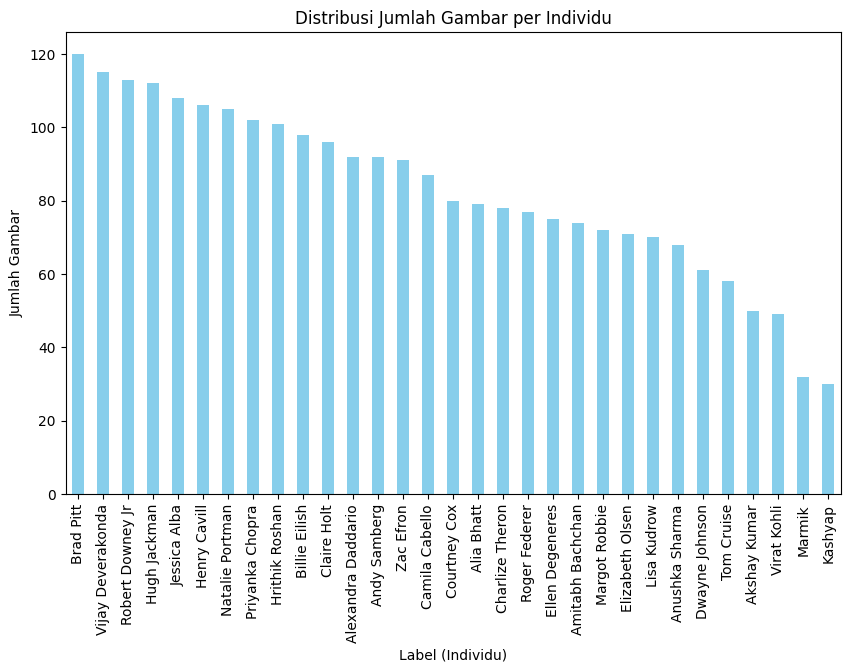

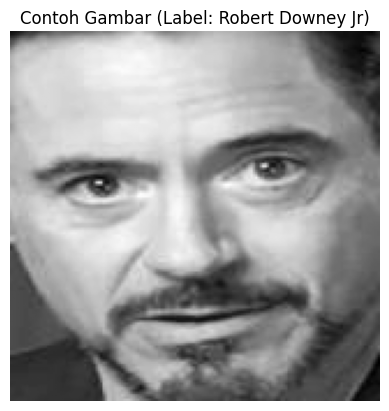


Resolusi Gambar yang Unik: {(160, 160)}


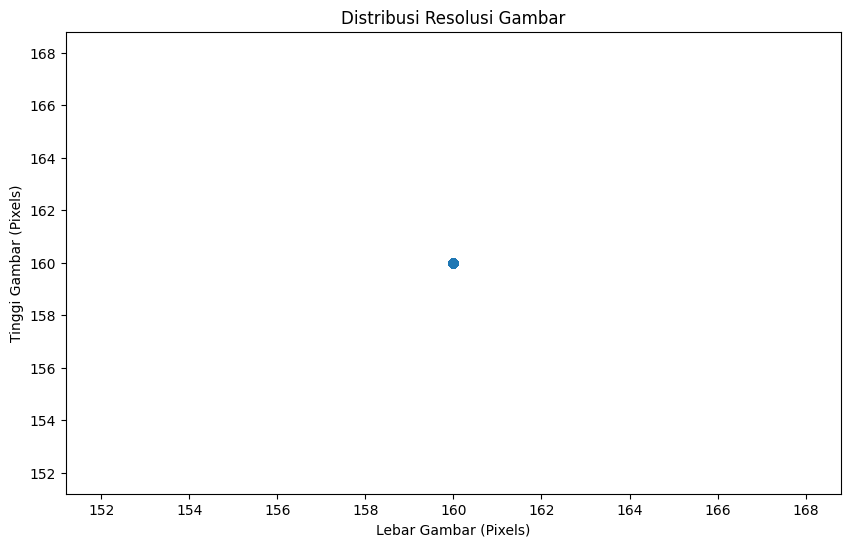


Proporsi Ketidakseimbangan Kelas (Distribusi Label):
label
Brad Pitt             0.046838
Vijay Deverakonda     0.044887
Robert Downey Jr      0.044106
Hugh Jackman          0.043716
Jessica Alba          0.042155
Henry Cavill          0.041374
Natalie Portman       0.040984
Priyanka Chopra       0.039813
Hrithik Roshan        0.039422
Billie Eilish         0.038251
Claire Holt           0.037471
Alexandra Daddario    0.035909
Andy Samberg          0.035909
Zac Efron             0.035519
Camila Cabello        0.033958
Courtney Cox          0.031226
Alia Bhatt            0.030835
Charlize Theron       0.030445
Roger Federer         0.030055
Ellen Degeneres       0.029274
Amitabh Bachchan      0.028884
Margot Robbie         0.028103
Elizabeth Olsen       0.027713
Lisa Kudrow           0.027322
Anushka Sharma        0.026542
Dwayne Johnson        0.023810
Tom Cruise            0.022639
Akshay Kumar          0.019516
Virat Kohli           0.019126
Marmik                0.012490
Kashyap   

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

csv_path = '/content/drive/MyDrive/PCD 2025/datasetPCD/Dataset.csv'
img_folder = '/content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces'

df = pd.read_csv(csv_path)
print("Jumlah data:", len(df))
print("Contoh isi dataset:")
print(df.head())

# distribusi label
print("\nDistribusi label:")
label_counts = df['label'].value_counts()
print(label_counts)

# Cek missing value
missing_images = []
for idx, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])
    if not os.path.exists(image_path):
        missing_images.append(image_path)

print(f"\nJumlah gambar yang hilang: {len(missing_images)}")

# Visualisasi distribusi jumlah gambar per individu
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribusi Jumlah Gambar per Individu")
plt.xlabel("Label (Individu)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=90)
plt.show()

# Visualisasi sampel gambar
sample_row = df.iloc[0]
sample_path = os.path.join(img_folder, sample_row['id'])

if os.path.exists(sample_path):
    img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(f"Contoh Gambar (Label: {sample_row['label']})")
    plt.axis('off')
    plt.show()

# Cek resolusi gambar dan potensi noise
resolutions = []
for idx, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])
    if os.path.exists(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resolutions.append(img.shape)
    else:
        resolutions.append((0, 0))

# cek resolusi outlier
unique_resolutions = set(resolutions)
print(f"\nResolusi Gambar yang Unik: {unique_resolutions}")

# Visualisasi resolusi gambar
res_height = [res[0] for res in resolutions if res != (0, 0)]
res_width = [res[1] for res in resolutions if res != (0, 0)]

plt.figure(figsize=(10, 6))
plt.scatter(res_width, res_height, alpha=0.5)
plt.title("Distribusi Resolusi Gambar")
plt.xlabel("Lebar Gambar (Pixels)")
plt.ylabel("Tinggi Gambar (Pixels)")
plt.show()

# cek imbalance kelas
class_imbalance = df['label'].value_counts(normalize=True)
print("\nProporsi Ketidakseimbangan Kelas (Distribusi Label):")
print(class_imbalance)

for idx, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])
    if os.path.exists(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mean_intensity = img.mean()
        if mean_intensity < 50:  # Menandakan gambar mungkin sangat gelap/noisy
            plt.imshow(img, cmap='gray')
            plt.title(f"Gambar dengan Potensi Noise (Label: {row['label']})")
            plt.axis('off')
            plt.show()
        break  # Hanya menampilkan satu contoh noise


2. pre-pocessing

wajah yg kebaca sementara 2000

In [ ]:
import cv2
import pandas as pd
import os
import numpy as np

# --- Konfigurasi (Sesuaikan Path Anda) ---
# --- Konfigurasi (Sesuaikan Path Anda) ---
csv_path = '/content/drive/MyDrive/PCD 2025/datasetPCD/Dataset.csv'
img_folder = '/content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces'
resize_dim = (160, 160) # Ukuran target untuk resize wajah

print("Memulai preprocessing TANPA deteksi Haar (menggunakan gambar langsung)...")

# Load data
try:
    df = pd.read_csv(csv_path)
except Exception as e:
    print(f"Error membaca CSV: {e}")
    exit()

# Array untuk menyimpan hasil preprocessing
images = []
labels = []
processed_count = 0
file_not_found_count = 0
read_error_count = 0

# --- Pemetaan Label String ke Integer ---
# Ini penting untuk LBPH Recognizer
unique_labels_str = sorted(df["label"].unique())
label_map = {name: i for i, name in enumerate(unique_labels_str)}
print(f"Pemetaan label ke integer dibuat untuk {len(label_map)} kelas.")

for index, row in df.iterrows():
    image_path = os.path.join(img_folder, row["id"])
    label_str = row["label"]

    if os.path.exists(image_path):
        try:
            # Baca langsung sebagai grayscale
            img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img_gray is None:
                # print(f"Warning: Gagal membaca gambar (mungkin corrupt): {image_path}") # Uncomment jika ingin lihat detail
                read_error_count += 1
                continue # Lewati gambar ini

            # --- Langsung Resize dan Histogram Equalization (TANPA DETEKSI) ---
            face_resized = cv2.resize(img_gray, resize_dim)
            face_eq = cv2.equalizeHist(face_resized)

            # Simpan hasil gambar dan label INTEGER
            images.append(face_eq)
            labels.append(label_map[label_str]) # Simpan label integer
            processed_count += 1

        except Exception as e:
             print(f"Error saat memproses {image_path}: {e}")
             read_error_count += 1 # Anggap sebagai error baca/proses
    else:
        # print(f"Warning: Gambar tidak ditemukan: {image_path}") # Uncomment jika ingin lihat detail
        file_not_found_count += 1

    if (index + 1) % 200 == 0:
        print(f"Memproses gambar ke-{index+1}/{len(df)}...")

print(f"\nPreprocessing (tanpa deteksi) selesai.")
print(f"Total gambar berhasil diproses: {processed_count}")
print(f"Gambar tidak ditemukan: {file_not_found_count}")
print(f"Gambar gagal dibaca/diproses: {read_error_count}")

# Konversi ke numpy array
if images:
    X_no_detect = np.array(images)
    y_no_detect = np.array(labels)
    print(f"\nJumlah wajah valid untuk training/testing: {X_no_detect.shape[0]}")
    print(f"Ukuran gambar (setelah resize): {X_no_detect.shape[1:]}")
    print(f"Contoh label integer: {y_no_detect[:5]}")
    print(f"Label integer unik: {np.unique(y_no_detect)}")
else:
    print("\nTidak ada gambar yang berhasil diproses.")
    X_no_detect, y_no_detect = np.array([]), np.array([])

# Anda bisa menyimpan X_no_detect dan y_no_detect ini
np.save("processed_images_no_detect.npy", X_no_detect)
np.save("processed_labels_no_detect.npy", y_no_detect)
print("\nData gambar dan label (tanpa deteksi) yang sudah diproses disimpan.")



Memulai preprocessing TANPA deteksi Haar (menggunakan gambar langsung)...
Pemetaan label ke integer dibuat untuk 31 kelas.
Memproses gambar ke-200/2562...
Memproses gambar ke-400/2562...
Memproses gambar ke-600/2562...
Memproses gambar ke-800/2562...
Memproses gambar ke-1000/2562...
Memproses gambar ke-1200/2562...
Memproses gambar ke-1400/2562...
Memproses gambar ke-1600/2562...
Memproses gambar ke-1800/2562...
Memproses gambar ke-2000/2562...
Memproses gambar ke-2200/2562...
Memproses gambar ke-2400/2562...

Preprocessing (tanpa deteksi) selesai.
Total gambar berhasil diproses: 2562
Gambar tidak ditemukan: 0
Gambar gagal dibaca/diproses: 0

Jumlah wajah valid untuk training/testing: 2562
Ukuran gambar (setelah resize): (160, 160)
Contoh label integer: [25 20 14  6 16]
Label integer unik: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

Data gambar dan label (tanpa deteksi) yang sudah diproses disimpan.


In [ ]:
import cv2
import pandas as pd
import os
import numpy as np

# Load data
df = pd.read_csv(csv_path)

# Load Haar Cascade untuk deteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Array untuk menyimpan hasil preprocessing
images = []
labels = []

for index, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])

    if os.path.exists(image_path):
        # Baca dan ubah ke grayscale
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Deteksi wajah
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            # Ambil wajah pertama yang terdeteksi
            (x, y, w, h) = faces[0]
            face_roi = gray[y:y+h, x:x+w]

            # Resize dan histogram equalization
            face_resized = cv2.resize(face_roi, (160, 160))
            face_eq = cv2.equalizeHist(face_resized)

            # Simpan hasil
            images.append(face_eq)
            labels.append(row['label'])
        else:
            print(f"Tidak ada wajah terdeteksi di: {image_path}")
    else:
        print(f"Gambar tidak ditemukan: {image_path}")

# Konversi ke numpy array
X = np.array(images)
y = np.array(labels)

print(f'Jumlah wajah valid: {X.shape[0]}, Ukuran gambar: {X.shape[1:]}')
print(f'Contoh label: {y[:5]}')


Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Robert Downey Jr_87.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Hrithik Roshan_35.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Tom Cruise_21.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Elizabeth Olsen_36.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Natalie Portman_74.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Priyanka Chopra_6.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Zac Efron_6.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Marmik_5.jpg
Tidak ada wajah terdeteksi di: /content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces/Claire Holt_28.jpg
Tidak ada wajah terdeteksi di: /content/drive/

KeyboardInterrupt: 

# **Ekstraksi fitur**

Setelah preprocessing, dilakukan ekstraksi fitur menggunakan teknik Local Binary Pattern (LBP), di mana setiap wajah dibagi menjadi grid dan dihitung histogram-nya. Vektor fitur hasil penggabungan seluruh grid inilah yang digunakan dalam model LBPH. LBP terbukti efektif dalam menangkap pola tekstur mikro wajah, dan digabungkan dalam histogram untuk klasifikasi identitas

In [ ]:
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder

X = np.load("processed_images_no_detect.npy")
y = np.load("processed_labels_no_detect.npy")
print("Data gambar dan label yang sudah diproses dimuat.")

# Parameter LBP
radius = 1  # radius lingkaran sekitar piksel pusat
n_points = 8 * radius  # jumlah titik di sekeliling
METHOD = 'uniform'

# Grid size (misal 8x8 grid)
grid_x = 8
grid_y = 8

# Dimensi gambar
img_h, img_w = X.shape[1], X.shape[2]
cell_h = img_h // grid_y
cell_w = img_w // grid_x

# Fungsi untuk ekstraksi fitur LBP histogram dari 1 gambar
def extract_lbp_features(img):
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    features = []

    for i in range(grid_y):
        for j in range(grid_x):
            y0, y1 = i * cell_h, (i + 1) * cell_h
            x0, x1 = j * cell_w, (j + 1) * cell_w
            cell = lbp[y0:y1, x0:x1]

            # Histogram dari LBP dalam cell
            hist, _ = np.histogram(cell.ravel(),
                                   bins=np.arange(0, n_points + 3),
                                   range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)  # normalisasi
            features.extend(hist)

    return features

# Ekstraksi fitur untuk semua gambar
X_features = [extract_lbp_features(img) for img in X]
X_features = np.array(X_features)

# Encode label (opsional untuk training)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Shape fitur:", X_features.shape)
print("Contoh fitur (5 pertama):", X_features[:5])
print("Contoh label:", y_encoded[:5])


Data gambar dan label yang sudah diproses dimuat.
Shape fitur: (2562, 640)
Contoh fitur (5 pertama): [[0.01   0.03   0.015  ... 0.035  0.135  0.1   ]
 [0.135  0.0925 0.06   ... 0.14   0.1025 0.145 ]
 [0.02   0.055  0.09   ... 0.0225 0.215  0.085 ]
 [0.05   0.1075 0.0325 ... 0.0525 0.06   0.11  ]
 [0.03   0.03   0.025  ... 0.06   0.14   0.07  ]]
Contoh label: [25 20 14  6 16]


# **modeling**

Pada tahap pelatihan model, dataset dibagi dan dilatih dengan parameter LBPH yang disesuaikan, kemudian diuji dengan berbagai metrik evaluasi. K-fold cross-validation juga penting untuk mengukur generalisasi model

In [ ]:
X = np.load("processed_images_no_detect.npy")
y = np.load("processed_labels_no_detect.npy")
print("Data gambar dan label yang sudah diproses dimuat.")

Data gambar dan label yang sudah diproses dimuat.


In [ ]:
# -*- coding: utf-8 -*-
"""
Hyperparameter Tuning for SVM (RBF Kernel) using GridSearchCV

This script performs hyperparameter tuning for an SVM classifier with an RBF kernel
using GridSearchCV. It incorporates StandardScaler within a pipeline and uses
Stratified K-Fold cross-validation to find the best combination of C and gamma
parameters for the LBP features.

Assumptions:
- `X_features`: NumPy array containing LBP feature vectors (shape: 2562, 640).
- `y_encoded`: NumPy array containing integer labels (shape: 2562,).
  (These should be the outputs from LBP extraction on the full dataset).
"""

import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import time
import warnings

# Suppress convergence warnings for cleaner output during grid search
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Configuration ---
CV_FOLDS = 5 # Number of folds for inner cross-validation within GridSearchCV
             # Using 5 instead of 10 to speed up the search slightly
RANDOM_STATE = 42
N_JOBS = -1 # Use all available CPU cores for parallel processing

# --- Load Pre-computed Features and Labels ---
# Make sure these variables are loaded or defined before running this script
try:
    # Placeholder check - replace with actual loading or ensure variables exist
    if 'X_features' not in locals() or 'y_encoded' not in locals():
         raise NameError("Variables 'X_features' and 'y_encoded' are not defined. Load them first.")
    if X_features.shape[0] != y_encoded.shape[0]:
         raise ValueError("Mismatch between number of samples in X_features and y_encoded.")
    if X_features.shape[0] < 2500:
         print(f"Warning: Loaded data has only {X_features.shape[0]} samples. Ensure you are using the full dataset (expected ~2562).")

    print(f"Loaded LBP features with shape: {X_features.shape}")
    print(f"Loaded labels with shape: {y_encoded.shape}")

except FileNotFoundError:
    print("Error: Feature or label files not found. Make sure to run LBP extraction first on the full dataset.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit()

# --- Define Pipeline and Parameter Grid ---
print("\n--- Setting up GridSearchCV --- ")

# Create a pipeline: StandardScaler -> SVC (RBF Kernel)
# Scaling is often important for RBF kernel performance
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=RANDOM_STATE))
])

# Define the parameter grid to search
# Using a logarithmic scale for C and gamma is common
# Adjust ranges if needed based on results or computational time
param_grid = {
    'svm__C': [0.1, 1, 10, 100], # Regularization parameter
    'svm__gamma': [0.001, 0.01, 0.1, 1] # Kernel coefficient
}

print(f"Parameter grid for C: {param_grid['svm__C']}")
print(f"Parameter grid for gamma: {param_grid['svm__gamma']}")

# Use StratifiedKFold for the cross-validation strategy within GridSearchCV
cv_strategy = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# --- Perform Grid Search ---
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy', # Evaluate based on accuracy
    cv=cv_strategy,
    n_jobs=N_JOBS, # Use parallel processing
    verbose=2 # Show progress
)

print(f"\nStarting GridSearchCV (this might take a while)...\n")
start_time_grid = time.time()

grid_search.fit(X_features, y_encoded)

end_time_grid = time.time()
print(f"\n--- GridSearchCV Finished --- ({end_time_grid - start_time_grid:.2f} seconds total)")

# --- Report Best Results ---
print("\n--- Best Results Found --- ")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# You can now use the best estimator found for final evaluation or deployment
best_svm_pipeline = grid_search.best_estimator_

# Optional: Evaluate the best model on the full dataset (or a hold-out set)
# This is just to show how to use the best model found
print("\nEvaluating the best model found by GridSearchCV on the full dataset...")
y_pred_best = best_svm_pipeline.predict(X_features)
print("Classification Report (Best Model on Full Data):")
try:
    if 'unique_labels_str' not in locals():
         unique_int_labels = sorted(np.unique(y_encoded))
         target_names = [f"Class_{i}" for i in unique_int_labels]
    else:
         target_names = unique_labels_str
    print(classification_report(y_encoded, y_pred_best, target_names=target_names, zero_division=0))
except Exception as e:
    print(f"Error generating report: {e}")
    print(classification_report(y_encoded, y_pred_best, zero_division=0))

print("\n--- Tuning Finished ---")



Loaded LBP features with shape: (2562, 640)
Loaded labels with shape: (2562,)

--- Setting up GridSearchCV --- 
Parameter grid for C: [0.1, 1, 10, 100]
Parameter grid for gamma: [0.001, 0.01, 0.1, 1]

Starting GridSearchCV (this might take a while)...

Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- GridSearchCV Finished --- (217.68 seconds total)

--- Best Results Found --- 
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.001}
Best Cross-Validation Accuracy: 0.6440

Evaluating the best model found by GridSearchCV on the full dataset...
Classification Report (Best Model on Full Data):
                    precision    recall  f1-score   support

      Akshay Kumar       1.00      1.00      1.00        50
Alexandra Daddario       1.00      1.00      1.00        92
        Alia Bhatt       1.00      1.00      1.00        79
  Amitabh Bachchan       1.00      1.00      1.00        74
      Andy Samberg       1.00      1.00      1.00        92
    Anushka Sharma       1.00

In [ ]:
# -*- coding: utf-8 -*-
"""
Final Model Training and Saving

This script trains the final, optimized SVM model (RBF kernel)
with StandardScaler on the entire LBP feature dataset and saves
the trained pipeline for later use.

Assumptions:
- `X_features`: NumPy array containing LBP feature vectors (shape: 2562, 640).
- `y_encoded`: NumPy array containing integer labels (shape: 2562,).
  (These should be the outputs from LBP extraction on the full dataset).
- `unique_labels_str`: List or array containing the original string names
  corresponding to the integer labels in `y_encoded`. This is needed
  if you want to save the label mapping alongside the model.
"""

import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib # For saving the model pipeline
import time

# --- Configuration: Best Parameters Found by GridSearchCV ---
BEST_C = 10
BEST_GAMMA = 0.001
RANDOM_STATE = 42
MODEL_FILENAME = "final_lbp_svm_model.joblib" # File to save the trained model
LABEL_MAP_FILENAME = "label_map.joblib" # File to save the label mapping

# --- Load Pre-computed Features and Labels ---
# Make sure these variables are loaded or defined before running this script
try:
    # Placeholder check - replace with actual loading or ensure variables exist
    if 'X_features' not in locals() or 'y_encoded' not in locals():
         raise NameError("Variables 'X_features' and 'y_encoded' are not defined. Load them first.")
    if X_features.shape[0] != y_encoded.shape[0]:
         raise ValueError("Mismatch between number of samples in X_features and y_encoded.")
    if X_features.shape[0] < 2500:
         print(f"Warning: Loaded data has only {X_features.shape[0]} samples. Ensure you are using the full dataset (expected ~2562).")

    # Also ensure unique_labels_str is available for saving the map
    if 'unique_labels_str' not in locals():
        # Attempt to reconstruct if needed, but saving the map is less useful then
        unique_int_labels = sorted(np.unique(y_encoded))
        unique_labels_str = [f"Class_{i}" for i in unique_int_labels]
        print("Warning: Original label names (unique_labels_str) not found. Saving generic map.")
        # raise NameError("Variable 'unique_labels_str' containing original names is not defined.")

    print(f"Loaded LBP features with shape: {X_features.shape}")
    print(f"Loaded labels with shape: {y_encoded.shape}")
    print(f"Number of unique string labels found: {len(unique_labels_str)}")

except FileNotFoundError:
    print("Error: Feature or label files not found. Make sure to run LBP extraction first on the full dataset.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit()

# --- Define the Final Optimized Pipeline ---
print("\n--- Defining Final Model Pipeline --- ")
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=BEST_C, gamma=BEST_GAMMA, random_state=RANDOM_STATE, probability=True)) # Set probability=True if you need probability scores later
])
print(f"Pipeline created: StandardScaler -> SVC(kernel='rbf', C={BEST_C}, gamma={BEST_GAMMA})")

# --- Train the Final Model on ALL Data ---
print(f"\nTraining the final model on all {len(X_features)} samples...")
start_time_train = time.time()

final_pipeline.fit(X_features, y_encoded)

end_time_train = time.time()
print(f"--- Final Model Training Finished --- ({end_time_train - start_time_train:.2f} seconds total)")

# --- Save the Trained Model Pipeline and Label Map ---
print(f"\nSaving the trained model pipeline to: {MODEL_FILENAME}")
joblib.dump(final_pipeline, MODEL_FILENAME)
print("Model pipeline saved successfully.")

# Create and save the label map (integer to string name)
label_map_int_to_str = {i: name for i, name in enumerate(unique_labels_str)}
print(f"Saving the label map (integer -> name) to: {LABEL_MAP_FILENAME}")
joblib.dump(label_map_int_to_str, LABEL_MAP_FILENAME)
print("Label map saved successfully.")

print("\n--- Process Complete --- ")
print(f"You can now load '{MODEL_FILENAME}' and '{LABEL_MAP_FILENAME}' to make predictions on new face images.")



Loaded LBP features with shape: (2562, 640)
Loaded labels with shape: (2562,)
Number of unique string labels found: 31

--- Defining Final Model Pipeline --- 
Pipeline created: StandardScaler -> SVC(kernel='rbf', C=10, gamma=0.001)

Training the final model on all 2562 samples...
--- Final Model Training Finished --- (18.79 seconds total)

Saving the trained model pipeline to: final_lbp_svm_model.joblib
Model pipeline saved successfully.
Saving the label map (integer -> name) to: label_map.joblib
Label map saved successfully.

--- Process Complete --- 
You can now load 'final_lbp_svm_model.joblib' and 'label_map.joblib' to make predictions on new face images.


In [ ]:
# -*- coding: utf-8 -*-
"""
Modeling using Manually Extracted LBP Features and K-Nearest Neighbors (KNN)

This script implements Option B (revised): using the pre-computed LBP features
(`X_features`) with KNN classifier and evaluates using Stratified K-Fold
Cross Validation.

Assumptions:
- `X_features`: NumPy array containing LBP feature vectors for each image.
- `y_encoded`: NumPy array containing integer labels corresponding to `X_features`.
  (These should be the outputs from your LBP feature extraction step on the full dataset).
"""

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier # Using KNN now
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time



# --- Configuration ---
K_FOLDS = 10 # Number of folds for cross-validation
RANDOM_STATE = 42 # Seed for reproducibility
N_NEIGHBORS = 5 # Number of neighbors for KNN (you can tune this)

# --- Load Pre-computed Features and Labels ---
# Make sure these variables are loaded or defined before running this script
# Example loading from saved files (if you saved them earlier):
try:
    # Assuming X_features was generated from the LBP extraction code on 2562 samples
    # And y_encoded was the integer labels for 2562 samples
    # Replace with your actual variable names if different
    # X_features = np.load("lbp_features_full.npy") # Example path
    # y_encoded = np.load("processed_labels_full.npy") # Example path

    # Placeholder check - replace with actual loading or ensure variables exist
    if 'X_features' not in locals() or 'y_encoded' not in locals():
         raise NameError("Variables 'X_features' and 'y_encoded' are not defined. Load them first.")
    if X_features.shape[0] != y_encoded.shape[0]:
         raise ValueError("Mismatch between number of samples in X_features and y_encoded.")
    if X_features.shape[0] < 2500: # Simple check if data seems incomplete
         print(f"Warning: Loaded data has only {X_features.shape[0]} samples. Ensure you are using the full dataset (expected ~2562).")

    print(f"Loaded LBP features with shape: {X_features.shape}")
    print(f"Loaded labels with shape: {y_encoded.shape}")

except FileNotFoundError:
    print("Error: Feature or label files not found. Make sure to run LBP extraction first on the full dataset.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit()

# --- Stratified K-Fold Cross Validation ---
print(f"\n--- Starting {K_FOLDS}-Fold Cross Validation with KNN Classifier (k={N_NEIGHBORS}) ---")
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

fold_accuracies = []
all_preds = []
all_true = []
fold_num = 1
start_time_cv = time.time()

for train_index, test_index in skf.split(X_features, y_encoded):
    print(f"\n--- Fold {fold_num}/{K_FOLDS} ---")
    start_time_fold = time.time()

    # Split data for this fold
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # --- Initialize and Train Classifier ---
    # Using K-Nearest Neighbors (KNN)
    print(f"Initializing KNN classifier with n_neighbors={N_NEIGHBORS}...")
    classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)

    print(f"Training classifier on {len(X_train)} samples...")
    # KNN's 'fit' is essentially just storing the data
    classifier.fit(X_train, y_train)
    print("Training complete.")

    # --- Predict on Test Set ---
    print(f"Predicting on {len(X_test)} samples...")
    y_pred = classifier.predict(X_test)

    # --- Evaluate Fold ---
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)
    all_preds.extend(y_pred)
    all_true.extend(y_test)

    end_time_fold = time.time()
    print(f"Fold {fold_num} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold_num} Time: {end_time_fold - start_time_fold:.2f} seconds")

    # Optional: Print classification report per fold
    # print(f"\nClassification Report (Fold {fold_num}):")
    # print(classification_report(y_test, y_pred, zero_division=0))

    fold_num += 1

end_time_cv = time.time()
print(f"\n--- Cross Validation Finished --- ({end_time_cv - start_time_cv:.2f} seconds total)")

# --- Overall Performance ---
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAverage Accuracy across {K_FOLDS} folds (KNN, k={N_NEIGHBORS}): {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")

print("\nOverall Classification Report (Aggregated - KNN):")
# You might need the label names (unique_labels_str from preprocessing) for target_names
# Ensure unique_labels_str is available or load it
try:
    # Assuming unique_labels_str is available from previous steps or loaded
    if 'unique_labels_str' not in locals():
         # Attempt to reconstruct from y_encoded if label_map isn't available
         unique_int_labels = sorted(np.unique(y_encoded))
         target_names = [f"Class_{i}" for i in unique_int_labels] # Placeholder names
         print("Warning: Original label names not found, using generic 'Class_X' names.")
    else:
         target_names = unique_labels_str

    print(classification_report(all_true, all_preds, target_names=target_names, zero_division=0))
except NameError:
     print("Warning: Could not find original label names for classification report.")
     print(classification_report(all_true, all_preds, zero_division=0))
except Exception as e:
     print(f"Error generating classification report: {e}")
     print(classification_report(all_true, all_preds, zero_division=0))


print("\nOverall Confusion Matrix (Aggregated - KNN):")
conf_matrix = confusion_matrix(all_true, all_preds)
print(conf_matrix)

# Optional: Visualize Confusion Matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 10))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Overall Confusion Matrix (KNN)")
# plt.show()

print("\n--- Modeling with KNN Finished ---")



Loaded LBP features with shape: (2562, 640)
Loaded labels with shape: (2562,)

--- Starting 10-Fold Cross Validation with KNN Classifier (k=5) ---

--- Fold 1/10 ---
Initializing KNN classifier with n_neighbors=5...
Training classifier on 2305 samples...
Training complete.
Predicting on 257 samples...
Fold 1 Accuracy: 0.4241
Fold 1 Time: 0.04 seconds

--- Fold 2/10 ---
Initializing KNN classifier with n_neighbors=5...
Training classifier on 2305 samples...
Training complete.
Predicting on 257 samples...
Fold 2 Accuracy: 0.3502
Fold 2 Time: 0.04 seconds

--- Fold 3/10 ---
Initializing KNN classifier with n_neighbors=5...
Training classifier on 2306 samples...
Training complete.
Predicting on 256 samples...
Fold 3 Accuracy: 0.4258
Fold 3 Time: 0.04 seconds

--- Fold 4/10 ---
Initializing KNN classifier with n_neighbors=5...
Training classifier on 2306 samples...
Training complete.
Predicting on 256 samples...
Fold 4 Accuracy: 0.4023
Fold 4 Time: 0.03 seconds

--- Fold 5/10 ---
Initializi

Data gambar dan label yang sudah diproses dimuat.
Loaded LBP features with shape: (2562, 640)
Loaded labels with shape: (2562,)

--- Starting 10-Fold Cross Validation with SVM Classifier ---

--- Fold 1/10 ---
Initializing SVM classifier...
Training classifier on 2305 samples...
Training complete.
Predicting on 257 samples...
Fold 1 Accuracy: 0.5759
Fold 1 Time: 2.11 seconds

--- Fold 2/10 ---
Initializing SVM classifier...
Training classifier on 2305 samples...
Training complete.
Predicting on 257 samples...
Fold 2 Accuracy: 0.5642
Fold 2 Time: 1.97 seconds

--- Fold 3/10 ---
Initializing SVM classifier...
Training classifier on 2306 samples...
Training complete.
Predicting on 256 samples...
Fold 3 Accuracy: 0.6289
Fold 3 Time: 1.64 seconds

--- Fold 4/10 ---
Initializing SVM classifier...
Training classifier on 2306 samples...
Training complete.
Predicting on 256 samples...
Fold 4 Accuracy: 0.6016
Fold 4 Time: 1.60 seconds

--- Fold 5/10 ---
Initializing SVM classifier...
Training cl

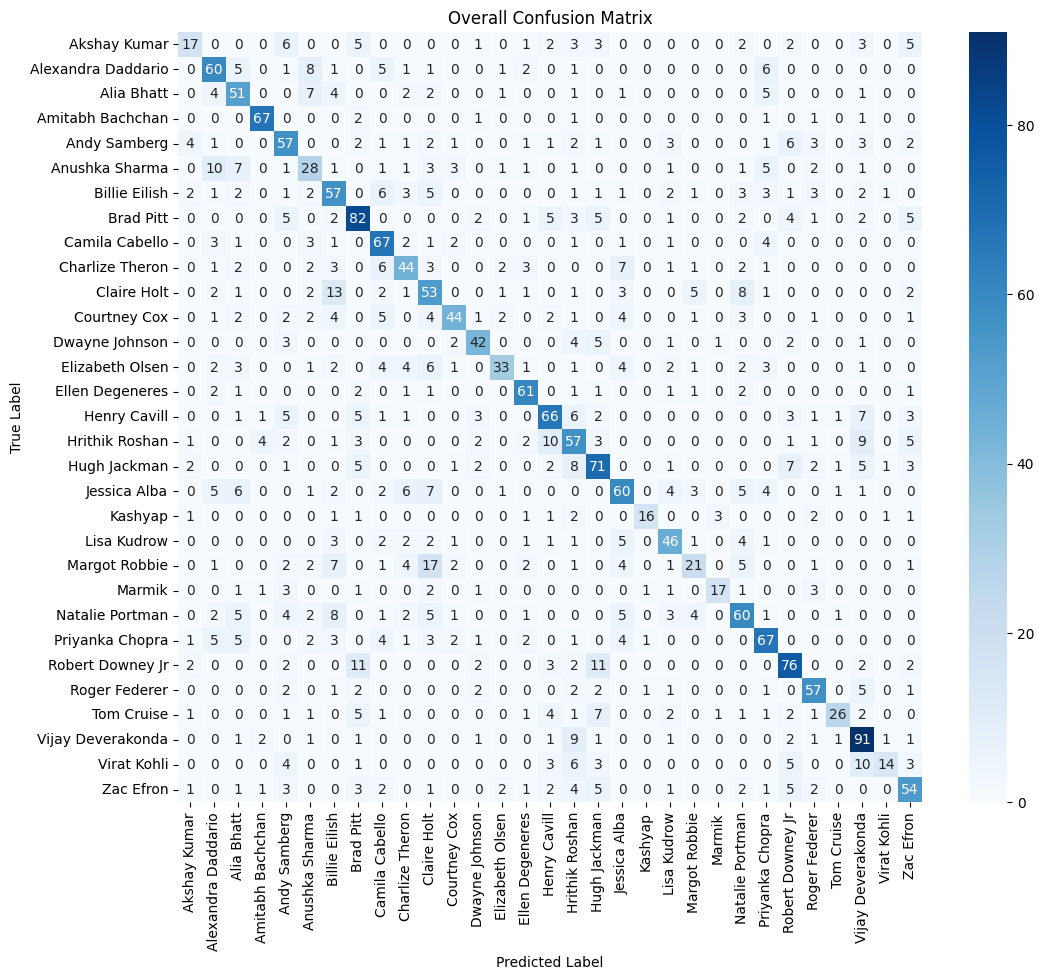


--- Modeling Finished ---


In [ ]:
# -*- coding: utf-8 -*-
"""
Modeling using Manually Extracted LBP Features and Scikit-learn Classifier

This script implements Option B: using the pre-computed LBP features
(`X_features`) with a standard classifier (e.g., SVM) and evaluates
using Stratified K-Fold Cross Validation.

Assumptions:
- `X_features`: NumPy array containing LBP feature vectors for each image.
- `y_encoded`: NumPy array containing integer labels corresponding to `X_features`.
  (These should be the outputs from your LBP feature extraction step).
"""

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC  # Example classifier: Support Vector Machine
# from sklearn.neighbors import KNeighborsClassifier # Alternative: K-Nearest Neighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

X = np.load("processed_images_no_detect.npy")
y = np.load("processed_labels_no_detect.npy")
print("Data gambar dan label yang sudah diproses dimuat.")

# --- Configuration ---
K_FOLDS = 10 # Number of folds for cross-validation
RANDOM_STATE = 42 # Seed for reproducibility

# --- Load Pre-computed Features and Labels ---
# Make sure these variables are loaded or defined before running this script
# Example loading from saved files (if you saved them earlier):
try:
    # Assuming X_features was generated from the LBP extraction code
    # And y_encoded was the integer labels (either from preprocessing or LabelEncoder)
    # Replace with your actual variable names if different
    # X_features = np.load("lbp_features.npy") # Example path
    # y_encoded = np.load("processed_labels.npy") # Example path (should be integer labels)

    # Placeholder check - replace with actual loading or ensure variables exist
    if 'X_features' not in locals() or 'y_encoded' not in locals():
         raise NameError("Variables 'X_features' and 'y_encoded' are not defined. Load them first.")

    print(f"Loaded LBP features with shape: {X_features.shape}")
    print(f"Loaded labels with shape: {y_encoded.shape}")

except FileNotFoundError:
    print("Error: Feature or label files not found. Make sure to run LBP extraction first.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit()

# --- Stratified K-Fold Cross Validation ---
print(f"\n--- Starting {K_FOLDS}-Fold Cross Validation with SVM Classifier ---")
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

fold_accuracies = []
all_preds = []
all_true = []
fold_num = 1
start_time_cv = time.time()

for train_index, test_index in skf.split(X_features, y_encoded):
    print(f"\n--- Fold {fold_num}/{K_FOLDS} ---")
    start_time_fold = time.time()

    # Split data for this fold
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # --- Initialize and Train Classifier ---
    # Using Support Vector Machine (SVC) with a linear kernel as an example
    # You can experiment with other kernels ('rbf', 'poly') or parameters (C)
    # Or use a different classifier like KNN:
    # classifier = KNeighborsClassifier(n_neighbors=5)
    print("Initializing SVM classifier...")
    classifier = SVC(kernel='linear', C=1.0, probability=False, random_state=RANDOM_STATE)

    print(f"Training classifier on {len(X_train)} samples...")
    classifier.fit(X_train, y_train)
    print("Training complete.")

    # --- Predict on Test Set ---
    print(f"Predicting on {len(X_test)} samples...")
    y_pred = classifier.predict(X_test)

    # --- Evaluate Fold ---
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)
    all_preds.extend(y_pred)
    all_true.extend(y_test)

    end_time_fold = time.time()
    print(f"Fold {fold_num} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold_num} Time: {end_time_fold - start_time_fold:.2f} seconds")

    # Optional: Print classification report per fold
    # print(f"\nClassification Report (Fold {fold_num}):")
    # print(classification_report(y_test, y_pred, zero_division=0))

    fold_num += 1

end_time_cv = time.time()
print(f"\n--- Cross Validation Finished --- ({end_time_cv - start_time_cv:.2f} seconds total)")

# --- Overall Performance ---
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAverage Accuracy across {K_FOLDS} folds: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")

print("\nOverall Classification Report (Aggregated):")
# You might need the label names (unique_labels_str from preprocessing) for target_names
# Ensure unique_labels_str is available or load it
# target_names = unique_labels_str # Replace with actual variable if needed
try:
    # Assuming unique_labels_str is available from previous steps or loaded
    if 'unique_labels_str' not in locals():
         # Attempt to reconstruct from y_encoded if label_map isn't available
         unique_int_labels = sorted(np.unique(y_encoded))
         target_names = [f"Class_{i}" for i in unique_int_labels] # Placeholder names
         print("Warning: Original label names not found, using generic 'Class_X' names.")
    else:
         target_names = unique_labels_str

    print(classification_report(all_true, all_preds, target_names=target_names, zero_division=0))
except NameError:
     print("Warning: Could not find original label names for classification report.")
     print(classification_report(all_true, all_preds, zero_division=0))
except Exception as e:
     print(f"Error generating classification report: {e}")
     print(classification_report(all_true, all_preds, zero_division=0))


print("\nOverall Confusion Matrix (Aggregated):")
conf_matrix = confusion_matrix(all_true, all_preds)
print(conf_matrix)

# Optional: Visualize Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Overall Confusion Matrix")
plt.show()

print("\n--- Modeling Finished ---")



#5

STEP 1: LOADING DATASET
Loading dataset...
Processing class: Virat Kohli
  Augmenting 46 more images for Virat Kohli
  Total images (after augmentation): 80
Processing class: Tom Cruise
  Augmenting 23 more images for Tom Cruise
  Total images (after augmentation): 80
Processing class: Marmik
  Augmenting 55 more images for Marmik
  Total images (after augmentation): 80
Processing class: Natalie Portman
  Total images (after augmentation): 103
Processing class: Zac Efron
  Total images (after augmentation): 85
Processing class: Priyanka Chopra
  Total images (after augmentation): 95
Processing class: Roger Federer
  Augmenting 27 more images for Roger Federer
  Total images (after augmentation): 80
Processing class: Robert Downey Jr
  Total images (after augmentation): 104
Processing class: Vijay Deverakonda
  Total images (after augmentation): 94
Processing class: Margot Robbie
  Augmenting 11 more images for Margot Robbie
  Total images (after augmentation): 80
Processing class: Henr

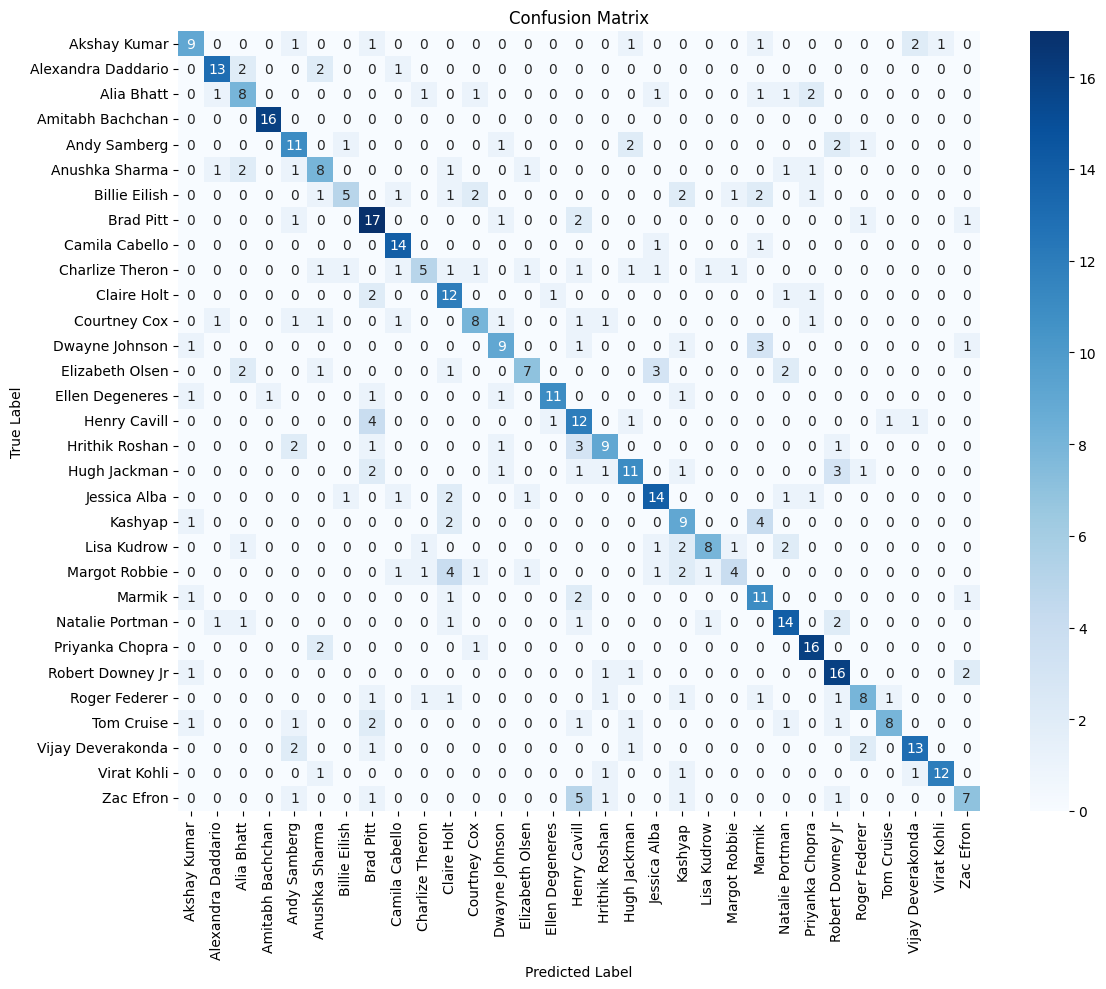


STEP 6: SAVING MODEL
Model saved to /content/face_recognition_model.pkl

STEP 7: TESTING INDIVIDUAL IMAGES

Final Model Accuracy: 0.6019


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
import pickle
import warnings
warnings.filterwarnings('ignore')

class FaceRecognitionPipeline:
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.label_encoder = LabelEncoder()
        self.model = None
        self.pca = None
        self.lbp_radius = 3
        self.lbp_n_points = 8 * self.lbp_radius
        self.image_size = (200, 200)

    def detect_face(self, image):
        """Deteksi wajah dalam gambar"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) > 0:
            # Ambil wajah terbesar
            largest_face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = largest_face
            face = gray[y:y+h, x:x+w]
            return face
        return None

    def preprocess_image(self, image_path):
        """Preprocessing gambar: deteksi wajah, resize, dan normalisasi"""
        try:
            # Baca gambar
            image = cv2.imread(image_path)
            if image is None:
                return None

            # Deteksi wajah
            face = self.detect_face(image)
            if face is None:
                return None

            # Resize ke ukuran standar
            face = cv2.resize(face, self.image_size)

            # Normalisasi histogram
            face = cv2.equalizeHist(face)

            # Noise reduction dengan Gaussian blur
            face = cv2.GaussianBlur(face, (3, 3), 0)

            return face

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None

    def extract_lbp_features(self, image):
        """Ekstraksi fitur menggunakan Local Binary Pattern"""
        # Hitung LBP
        lbp = local_binary_pattern(image, self.lbp_n_points, self.lbp_radius, method='uniform')

        # Hitung histogram
        n_bins = self.lbp_n_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        # Normalisasi histogram
        hist = hist / (np.linalg.norm(hist) + 1e-7)

        return hist

    def extract_lbph_features(self, image, grid_x=8, grid_y=8):
        """Ekstraksi fitur menggunakan Local Binary Pattern Histogram"""
        height, width = image.shape
        grid_h, grid_w = height // grid_y, width // grid_x

        features = []

        for i in range(grid_y):
            for j in range(grid_x):
                # Ambil region
                y_start, y_end = i * grid_h, (i + 1) * grid_h
                x_start, x_end = j * grid_w, (j + 1) * grid_w
                region = image[y_start:y_end, x_start:x_end]

                # Ekstraksi LBP untuk region ini
                lbp_hist = self.extract_lbp_features(region)
                features.extend(lbp_hist)

        return np.array(features)

    def augment_image(self, img):
        """Augmentasi sederhana: flip, rotasi, blur"""
        augmented_images = []

        # Flip horizontal
        flipped = cv2.flip(img, 1)
        augmented_images.append(flipped)

        # Rotasi -10 dan 10 derajat
        rows, cols = img.shape
        for angle in [-10, 10]:
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            rotated = cv2.warpAffine(img, M, (cols, rows))
            augmented_images.append(rotated)

        # Gaussian blur
        blurred = cv2.GaussianBlur(img, (3, 3), 0)
        augmented_images.append(blurred)

        return augmented_images

    def load_dataset(self, dataset_path, min_images_per_class=110):
        """Load dataset dan augmentasi kelas minoritas"""
        print("Loading dataset...")
        features = []
        labels = []
        class_names = []

        # Iterasi setiap kelas
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            if not os.path.isdir(class_path):
                continue

            class_names.append(class_name)
            print(f"Processing class: {class_name}")

            image_list = []
            image_count = 0

            for image_name in os.listdir(class_path):
                if not image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    continue

                image_path = os.path.join(class_path, image_name)
                face = self.preprocess_image(image_path)
                if face is not None:
                    image_list.append(face)
                    image_count += 1

            # Tambahkan fitur asli
            for face in image_list:
                lbph_features = self.extract_lbph_features(face)
                features.append(lbph_features)
                labels.append(class_name)

            # Augmentasi jika jumlah gambar < minimum
            if image_count < min_images_per_class:
                needed = min_images_per_class - image_count
                print(f"  Augmenting {needed} more images for {class_name}")

                augment_index = 0
                while needed > 0:
                    face = image_list[augment_index % len(image_list)]
                    augmented = self.augment_image(face)
                    for aug_face in augmented:
                        lbph_features = self.extract_lbph_features(aug_face)
                        features.append(lbph_features)
                        labels.append(class_name)
                        needed -= 1
                        if needed <= 0:
                            break
                    augment_index += 1

            print(f"  Total images (after augmentation): {labels.count(class_name)}")

        print(f"Total classes: {len(class_names)}")
        print(f"Total samples: {len(features)}")

        return np.array(features), np.array(labels), class_names

    def train_model(self, X_train, y_train, model_type='svm', use_pca=True, n_components=100):
        """Training model"""
        print("Training model...")

        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)

        # Dimensionality reduction dengan PCA (opsional)
        if use_pca:
            print(f"Applying PCA with {n_components} components...")
            self.pca = PCA(n_components=n_components)
            X_train = self.pca.fit_transform(X_train)

        # Pilih model
        if model_type == 'svm':
            self.model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        elif model_type == 'rf':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            raise ValueError("Model type harus 'svm' atau 'rf'")

        # Training
        self.model.fit(X_train, y_train_encoded)
        print("Training completed!")

        return X_train

    def evaluate_model(self, X_test, y_test):
        """Evaluasi model"""
        print("Evaluating model...")

        # Encode test labels
        y_test_encoded = self.label_encoder.transform(y_test)

        # Transform test data jika menggunakan PCA
        if self.pca is not None:
            X_test = self.pca.transform(X_test)

        # Prediksi
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)

        # Hitung akurasi
        accuracy = accuracy_score(y_test_encoded, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test_encoded, y_pred,
                                  target_names=self.label_encoder.classes_))

        # Confusion matrix
        cm = confusion_matrix(y_test_encoded, y_pred)

        return accuracy, y_pred, y_pred_proba, cm

    def plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix"""
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def predict_single_image(self, image_path, confidence_threshold=0.5):
        """Prediksi untuk satu gambar"""
        # Preprocessing
        face = self.preprocess_image(image_path)
        if face is None:
            return None, 0

        # Ekstraksi fitur
        features = self.extract_lbph_features(face)
        features = features.reshape(1, -1)

        # Transform dengan PCA jika ada
        if self.pca is not None:
            features = self.pca.transform(features)

        # Prediksi
        prediction = self.model.predict(features)[0]
        probabilities = self.model.predict_proba(features)[0]
        confidence = np.max(probabilities)

        # Decode label
        predicted_class = self.label_encoder.inverse_transform([prediction])[0]

        if confidence >= confidence_threshold:
            return predicted_class, confidence
        else:
            return "Unknown", confidence

    def save_model(self, model_path):
        """Simpan model"""
        model_data = {
            'model': self.model,
            'label_encoder': self.label_encoder,
            'pca': self.pca,
            'lbp_radius': self.lbp_radius,
            'lbp_n_points': self.lbp_n_points,
            'image_size': self.image_size
        }

        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path):
        """Load model"""
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.label_encoder = model_data['label_encoder']
        self.pca = model_data['pca']
        self.lbp_radius = model_data['lbp_radius']
        self.lbp_n_points = model_data['lbp_n_points']
        self.image_size = model_data['image_size']

        print(f"Model loaded from {model_path}")

# Fungsi utama untuk menjalankan pipeline
def run_face_recognition_pipeline():
    # Inisialisasi pipeline
    pipeline = FaceRecognitionPipeline()

    # Path dataset
    dataset_path = '/content/drive/MyDrive/Dataset PCD/Original Images/Original Images'
    test_images_path = '/content/drive/MyDrive/Dataset PCD/Faces/Faces'  # Ganti dengan path test images Anda

    # 1. Load dataset
    print("="*50)
    print("STEP 1: LOADING DATASET")
    print("="*50)
    features, labels, class_names = pipeline.load_dataset(dataset_path)

    # 2. Split dataset
    print("\n" + "="*50)
    print("STEP 2: SPLITTING DATASET")
    print("="*50)
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training set: {len(X_train)} samples")
    print(f"Testing set: {len(X_test)} samples")

    # 3. Training model
    print("\n" + "="*50)
    print("STEP 3: TRAINING MODEL")
    print("="*50)
    X_train_transformed = pipeline.train_model(X_train, y_train, model_type='svm', use_pca=True)

    # 4. Evaluasi model
    print("\n" + "="*50)
    print("STEP 4: MODEL EVALUATION")
    print("="*50)
    accuracy, y_pred, y_pred_proba, cm = pipeline.evaluate_model(X_test, y_test)

    # 5. Plot confusion matrix
    print("\n" + "="*50)
    print("STEP 5: VISUALIZATION")
    print("="*50)
    pipeline.plot_confusion_matrix(cm, pipeline.label_encoder.classes_)

    # 6. Simpan model
    print("\n" + "="*50)
    print("STEP 6: SAVING MODEL")
    print("="*50)
    pipeline.save_model('/content/face_recognition_model.pkl')

    # 7. Test dengan gambar individual (contoh)
    print("\n" + "="*50)
    print("STEP 7: TESTING INDIVIDUAL IMAGES")
    print("="*50)
    # Ganti dengan path gambar test Anda
    # test_image_path = '/path/to/test/image.jpg'
    # predicted_class, confidence = pipeline.predict_single_image(test_image_path)
    # print(f"Predicted: {predicted_class}, Confidence: {confidence:.4f}")

    return pipeline, accuracy

# Fungsi untuk testing dengan folder test images
def test_with_folder(pipeline, test_folder_path):
    """Test model dengan folder berisi gambar test"""
    print("Testing with folder images...")
    results = []

    for image_name in os.listdir(test_folder_path):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue

        image_path = os.path.join(test_folder_path, image_name)
        predicted_class, confidence = pipeline.predict_single_image(image_path)

        results.append({
            'image': image_name,
            'predicted_class': predicted_class,
            'confidence': confidence
        })

        print(f"{image_name}: {predicted_class} (confidence: {confidence:.4f})")

    return results

# Fungsi untuk visualisasi sample predictions
def visualize_predictions(pipeline, test_folder_path, num_samples=6):
    """Visualisasi prediksi untuk beberapa sample gambar"""
    test_images = [f for f in os.listdir(test_folder_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    # Ambil sample random
    sample_images = np.random.choice(test_images, min(num_samples, len(test_images)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(test_folder_path, image_name)

        # Load dan preprocess gambar
        face = pipeline.preprocess_image(image_path)
        if face is None:
            continue

        # Prediksi
        predicted_class, confidence = pipeline.predict_single_image(image_path)

        # Plot
        axes[i].imshow(face, cmap='gray')
        axes[i].set_title(f'{predicted_class}\nConf: {confidence:.3f}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Jalankan pipeline
    pipeline, accuracy = run_face_recognition_pipeline()
    print(f"\nFinal Model Accuracy: {accuracy:.4f}")

# yaaaa

## **Library**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from google.colab import drive
drive.mount('/content/drive')

## **Load Data**

In [ ]:
csv_path = '/content/drive/MyDrive/PCD 2025/datasetPCD/Dataset.csv'
training_folder = '/content/drive/MyDrive/PCD 2025/datasetPCD/Original Images/Original Images'
testing_folder = '/content/drive/MyDrive/PCD 2025/datasetPCD/Faces/Faces'

df = pd.read_csv(csv_path)
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nUnique Labels:", df['label'].nunique())
print("\nLabel Distribution:")
print(df['label'].value_counts())

def load_images_from_folder(folder_path, label_df):
    images = []
    labels = []
    image_names = []

    for artist_folder in os.listdir(folder_path):
        artist_path = os.path.join(folder_path, artist_folder)

        if os.path.isdir(artist_path):
            for img_name in os.listdir(artist_path):
                img_path = os.path.join(artist_path, img_name)

                img = cv2.imread(img_path)
                if img is not None:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(gray)
                    labels.append(artist_folder)
                    image_names.append(img_name)

    return images, labels, image_names

train_images, train_labels, train_names = load_images_from_folder(training_folder, df)
print(f"Total training images loaded: {len(train_images)}")
print(f"Unique artists: {len(set(train_labels))}")

# plt.figure(figsize=(12, 6))
# df['label'].value_counts().plot(kind='bar')
# plt.title('Distribusi Artis dalam Dataset')
# plt.xlabel('Nama Artis')
# plt.ylabel('Jumlah Gambar')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


## **EDA**

In [ ]:
# 2. ANALISIS DISTRIBUSI LABEL
print("\n\n2. ANALISIS DISTRIBUSI LABEL")
print("-"*40)
label_counts = df['label'].value_counts().sort_index()
unique_labels = df['label'].nunique()

print(f"✓ Jumlah kelas/individu unik: {unique_labels}")
print(f"✓ Total sampel per kelas:")
for label, count in label_counts.items():
    print(f"   - {label}: {count} gambar")

# Statistik distribusi
print(f"\nStatistik distribusi:")
print(f"   - Rata-rata sampel per kelas: {label_counts.mean():.2f}")
print(f"   - Median sampel per kelas: {label_counts.median():.2f}")
print(f"   - Std deviasi: {label_counts.std():.2f}")
print(f"   - Min sampel: {label_counts.min()}")
print(f"   - Max sampel: {label_counts.max()}")

# 3. CEK KEBERADAAN FILE GAMBAR
print("\n\n3. VALIDASI KEBERADAAN FILE GAMBAR")
print("-"*40)
missing_images = []
existing_images = []
corrupted_images = []

for idx, row in df.iterrows():
    image_path = os.path.join(img_folder, row['id'])

    if not os.path.exists(image_path):
        missing_images.append((idx, row['id'], row['label']))
    else:
        # Cek apakah gambar bisa dibaca
        try:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                corrupted_images.append((idx, row['id'], row['label']))
            else:
                existing_images.append((idx, row['id'], row['label']))
        except:
            corrupted_images.append((idx, row['id'], row['label']))

print(f"✓ Gambar yang tersedia: {len(existing_images)}")
print(f"✗ Gambar yang hilang: {len(missing_images)}")
print(f"✗ Gambar yang corrupt: {len(corrupted_images)}")

if missing_images:
    print(f"\nContoh gambar yang hilang:")
    for i, (idx, img_id, label) in enumerate(missing_images[:5]):
        print(f"   - Index {idx}: {img_id} (Label: {label})")

# 4. ANALISIS RESOLUSI GAMBAR
print("\n\n4. ANALISIS RESOLUSI GAMBAR")
print("-"*40)
resolutions = []
file_sizes = []

for idx, img_id, label in existing_images:
    image_path = os.path.join(img_folder, img_id)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resolutions.append(img.shape)
    file_sizes.append(os.path.getsize(image_path))

if resolutions:
    unique_resolutions = list(set(resolutions))
    print(f"✓ Resolusi unik yang ditemukan: {len(unique_resolutions)}")

    resolution_counts = Counter(resolutions)
    print(f"✓ Distribusi resolusi:")
    for res, count in sorted(resolution_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"   - {res[1]}x{res[0]}: {count} gambar ({count/len(resolutions)*100:.1f}%)")

    # Statistik resolusi
    heights = [res[0] for res in resolutions]
    widths = [res[1] for res in resolutions]

    print(f"\nStatistik resolusi:")
    print(f"   - Tinggi: min={min(heights)}, max={max(heights)}, rata-rata={np.mean(heights):.1f}")
    print(f"   - Lebar: min={min(widths)}, max={max(widths)}, rata-rata={np.mean(widths):.1f}")

# 5. ANALISIS KUALITAS GAMBAR
print("\n\n5. ANALISIS KUALITAS GAMBAR")
print("-"*40)
brightness_stats = []
contrast_stats = []
blur_stats = []

sample_size = min(100, len(existing_images))  # Analisis sample untuk efisiensi
print(f"Menganalisis kualitas dari {sample_size} gambar sample...")

for i in range(sample_size):
    idx, img_id, label = existing_images[i]
    image_path = os.path.join(img_folder, img_id)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Brightness (rata-rata intensitas pixel)
    brightness = np.mean(img)
    brightness_stats.append(brightness)

    # Contrast (standar deviasi intensitas pixel)
    contrast = np.std(img)
    contrast_stats.append(contrast)

    # Blur detection (varian Laplacian)
    blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
    blur_stats.append(blur_score)

if brightness_stats:
    print(f"✓ Statistik Kecerahan:")
    print(f"   - Rata-rata: {np.mean(brightness_stats):.1f}")
    print(f"   - Min: {np.min(brightness_stats):.1f}, Max: {np.max(brightness_stats):.1f}")

    print(f"✓ Statistik Kontras:")
    print(f"   - Rata-rata: {np.mean(contrast_stats):.1f}")
    print(f"   - Min: {np.min(contrast_stats):.1f}, Max: {np.max(contrast_stats):.1f}")

    print(f"✓ Statistik Blur (semakin tinggi = semakin tajam):")
    print(f"   - Rata-rata: {np.mean(blur_stats):.1f}")
    print(f"   - Min: {np.min(blur_stats):.1f}, Max: {np.max(blur_stats):.1f}")

    # Identifikasi gambar bermasalah
    very_dark = sum(1 for b in brightness_stats if b < 50)
    very_bright = sum(1 for b in brightness_stats if b > 200)
    low_contrast = sum(1 for c in contrast_stats if c < 20)
    very_blurry = sum(1 for bl in blur_stats if bl < 100)

    print(f"\n⚠️  Potensi masalah kualitas:")
    print(f"   - Gambar terlalu gelap (< 50): {very_dark}")
    print(f"   - Gambar terlalu terang (> 200): {very_bright}")
    print(f"   - Kontras rendah (< 20): {low_contrast}")
    print(f"   - Gambar blur (< 100): {very_blurry}")

# 6. ANALISIS CLASS IMBALANCE
print("\n\n6. ANALISIS KESEIMBANGAN KELAS")
print("-"*40)
class_proportions = df['label'].value_counts(normalize=True).sort_index()

print(f"✓ Proporsi setiap kelas:")
for label, prop in class_proportions.items():
    print(f"   - {label}: {prop:.3f} ({prop*100:.1f}%)")

# Hitung imbalance ratio
max_samples = label_counts.max()
min_samples = label_counts.min()
imbalance_ratio = max_samples / min_samples

print(f"\n✓ Analisis keseimbangan:")
print(f"   - Rasio ketidakseimbangan: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print(f"   ⚠️  Dataset tidak seimbang - pertimbangkan teknik balancing")
else:
    print(f"   ✓ Dataset relatif seimbang")

# 7. VISUALISASI
print("\n\n7. MEMBUAT VISUALISASI")
print("-"*40)

# Visualisasi 1: Distribusi Label
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
label_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title("Distribusi Jumlah Gambar per Individu", fontsize=12, fontweight='bold')
plt.xlabel("Label (Individu)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Visualisasi 2: Distribusi Resolusi
if resolutions:
    plt.subplot(2, 2, 2)
    heights = [res[0] for res in resolutions]
    widths = [res[1] for res in resolutions]
    plt.scatter(widths, heights, alpha=0.6, c='coral')
    plt.title("Distribusi Resolusi Gambar", fontsize=12, fontweight='bold')
    plt.xlabel("Lebar (pixels)")
    plt.ylabel("Tinggi (pixels)")
    plt.grid(True, alpha=0.3)

# Visualisasi 3: Distribusi Kualitas Gambar
if brightness_stats:
    plt.subplot(2, 2, 3)
    plt.hist(brightness_stats, bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
    plt.title("Distribusi Kecerahan Gambar", fontsize=12, fontweight='bold')
    plt.xlabel("Nilai Kecerahan")
    plt.ylabel("Frekuensi")
    plt.grid(axis='y', alpha=0.3)

# Visualisasi 4: Class Balance
plt.subplot(2, 2, 4)
colors = plt.cm.Set3(np.linspace(0, 1, len(class_proportions)))
plt.pie(class_proportions.values, labels=class_proportions.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title("Proporsi Kelas", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 8. MENAMPILKAN CONTOH GAMBAR
print("\n8. CONTOH GAMBAR DARI DATASET")
print("-"*40)

if existing_images:
    # Tampilkan contoh dari setiap kelas
    plt.figure(figsize=(15, 10))

    samples_per_class = {}
    for idx, img_id, label in existing_images:
        if label not in samples_per_class:
            samples_per_class[label] = []
        if len(samples_per_class[label]) < 3:  # Maksimal 3 contoh per kelas
            samples_per_class[label].append((img_id, idx))

    plot_idx = 1
    for label, samples in samples_per_class.items():
        for img_id, idx in samples:
            if plot_idx > 15:  # Batasi tampilan
                break

            image_path = os.path.join(img_folder, img_id)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            plt.subplot(3, 5, plot_idx)
            plt.imshow(img, cmap='gray')
            plt.title(f"Label: {label}\nSize: {img.shape}", fontsize=8)
            plt.axis('off')
            plot_idx += 1

        if plot_idx > 15:
            break

    plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## **Preprocessing and Data Preparation**

### **Face Detection dan Cropping**

In [ ]:
def detect_and_crop_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        padding = int(0.1 * w)
        y1 = max(0, y - padding)
        y2 = min(image.shape[0], y + h + padding)
        x1 = max(0, x - padding)
        x2 = min(image.shape[1], x + w + padding)

        face_crop = image[y1:y2, x1:x2]
        return face_crop
    else:
        return image

print("Detecting and cropping faces...")
cropped_faces = []
valid_labels = []
valid_names = []

for i, (img, label, name) in enumerate(zip(train_images, train_labels, train_names)):
    face = detect_and_crop_face(img)
    if face is not None and face.size > 0:
        cropped_faces.append(face)
        valid_labels.append(label)
        valid_names.append(name)

    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(train_images)} images")

print(f"Successfully cropped {len(cropped_faces)} faces")

### **Data Augmented**

In [ ]:
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)

        flipped = cv2.flip(img, 1)
        augmented_images.append(flipped)
        augmented_labels.append(label)

        bright = cv2.convertScaleAbs(img, alpha=1.2, beta=10)
        dark = cv2.convertScaleAbs(img, alpha=0.8, beta=-10)
        augmented_images.append(bright)
        augmented_labels.append(label)
        augmented_images.append(dark)
        augmented_labels.append(label)

    return augmented_images, augmented_labels

print("Augmenting data...")
augmented_faces, augmented_labels = augment_data(cropped_faces, valid_labels)
print(f"Augmented data size: {len(augmented_faces)}")

### **Resize Images**

In [ ]:
def resize_images(images, size=(128, 128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, size)
        resized_images.append(resized)
    return np.array(resized_images)

resized_faces = resize_images(augmented_faces)
print(f"Resized faces shape: {resized_faces.shape}")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(resized_faces):
        ax.imshow(resized_faces[i], cmap='gray')
        ax.set_title(valid_labels[i])
        ax.axis('off')
plt.suptitle('Sample Cropped and Resized Faces')
plt.tight_layout()
plt.show()


### **Local Binary Pattern (LBP) Implementation**

In [ ]:
def calculate_lbp(image, radius=1, n_points=8):
    rows, cols = image.shape
    lbp_image = np.zeros_like(image)

    for i in range(radius, rows - radius):
        for j in range(radius, cols - radius):
            center = image[i, j]
            binary_code = 0

            for p in range(n_points):
                theta = 2 * np.pi * p / n_points
                neighbor_x = i + radius * np.cos(theta)
                neighbor_y = j + radius * np.sin(theta)

                x1, y1 = int(neighbor_x), int(neighbor_y)
                x2, y2 = x1 + 1, y1 + 1

                x1 = max(0, min(x1, rows - 1))
                x2 = max(0, min(x2, rows - 1))
                y1 = max(0, min(y1, cols - 1))
                y2 = max(0, min(y2, cols - 1))

                fx = neighbor_x - x1
                fy = neighbor_y - y1

                neighbor_value = (1 - fx) * (1 - fy) * image[x1, y1] + \
                                fx * (1 - fy) * image[x2, y1] + \
                                (1 - fx) * fy * image[x1, y2] + \
                                fx * fy * image[x2, y2]

                if neighbor_value >= center:
                    binary_code |= (1 << p)

            lbp_image[i, j] = binary_code

    return lbp_image

#### **Visualize LBP**

In [ ]:
def visualize_lbp(image):
    lbp_image = calculate_lbp(image)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(lbp_image, cmap='gray')
    axes[1].set_title('LBP Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_lbp(resized_faces)

### **Local Binary Pattern Histogram (LBPH) Implementation**

In [ ]:
def calculate_lbph(image, radius=1, n_points=8, grid_x=8, grid_y=8):
    lbp_image = calculate_lbp(image, radius, n_points)

    height, width = lbp_image.shape
    grid_height = height // grid_y
    grid_width = width // grid_x

    histograms = []

    for i in range(grid_y):
        for j in range(grid_x):
            y1 = i * grid_height
            y2 = (i + 1) * grid_height if i < grid_y - 1 else height
            x1 = j * grid_width
            x2 = (j + 1) * grid_width if j < grid_x - 1 else width

            grid = lbp_image[y1:y2, x1:x2]

            hist, _ = np.histogram(grid, bins=2**n_points, range=(0, 2**n_points))
            histograms.append(hist)

    feature_vector = np.concatenate(histograms)

    feature_vector = feature_vector / (feature_vector.sum() + 1e-7)

    return feature_vector

print("Extracting LBPH features...")
lbph_features = []
for i, face in enumerate(resized_faces):
    features = calculate_lbph(face, radius=1, n_points=8, grid_x=8, grid_y=8)
    lbph_features.append(features)

    if (i + 1) % 50 == 0:
        print(f"Extracted features for {i + 1}/{len(resized_faces)} images")

lbph_features = np.array(lbph_features)
print(f"LBPH features shape: {lbph_features.shape}")

### **Label Encoding**

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(valid_labels)
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

### **Data Split for Training and Validation**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    lbph_features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

## **Features Selection Using PCA**

In [ ]:
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print(f"Original features: {X_train.shape[1]}")
print(f"PCA features: {X_train_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(10, 6))
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## **Training Set**

### **Support Vector Classification**

In [ ]:
print("Training SVC model...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=901)
svm_model.fit(X_train_pca, y_train)
svm_pred = svm_model.predict(X_val_pca)
svm_accuracy = accuracy_score(y_val, svm_pred)
print(f"SVC Accuracy: {svm_accuracy:.4f}")

### **Random Forest**

In [ ]:
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=901, n_jobs=-1)
rf_model.fit(X_train_pca, y_train)
rf_pred = rf_model.predict(X_val_pca)
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

### **KNN**

In [ ]:
print("\nTraining KNN model...")
knn_model = KNeighborsClassifier(n_neighbors=7, metric='cosine')
knn_model.fit(X_train_pca, y_train)
knn_pred = knn_model.predict(X_val_pca)
knn_accuracy = accuracy_score(y_val, knn_pred)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

## **Validation Set**

### **RF Validation**

In [ ]:
best_model = rf_model
best_pred = rf_pred
best_accuracy = rf_accuracy

print(f"\nBest Model: RF with accuracy {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, best_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **KNN Validation**

In [ ]:
best_model = knn_model
best_pred = knn_pred
best_accuracy = knn_accuracy

print(f"\nBest Model: KNN with accuracy {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, best_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **SVC Validation**

In [ ]:
best_model = svm_model
best_pred = svm_pred
best_accuracy = svm_accuracy

print(f"\nBest Model: SVM with accuracy {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, best_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Testing Set**

### **Load Testing Data**

In [ ]:
def load_test_images(test_folder):
    test_images = []
    test_names = []

    for img_name in os.listdir(test_folder):
        img_path = os.path.join(test_folder, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            test_images.append(gray)
            test_names.append(img_name)

    return test_images, test_names

print("Loading test images...")
test_images, test_names = load_test_images(testing_folder)
print(f"Loaded {len(test_images)} test images")

### **Data Preparation for Testing Set**

In [ ]:
test_cropped = []
valid_test_names = []

for img, name in zip(test_images, test_names):
    face = detect_and_crop_face(img)
    if face is not None and face.size > 0:
        test_cropped.append(face)
        valid_test_names.append(name)

test_resized = resize_images(test_cropped)

print("Extracting features from test images...")
test_features = []
for face in test_resized:
    features = calculate_lbph(face, radius=1, n_points=8, grid_x=8, grid_y=8)
    test_features.append(features)

test_features = np.array(test_features)

test_features_pca = pca.transform(test_features)

### **Predict Test Images**

In [ ]:
test_predictions = best_model.predict(test_features_pca)
test_pred_labels = label_encoder.inverse_transform(test_predictions)

results_df = pd.DataFrame({
    'image_name': valid_test_names,
    'predicted_artist': test_pred_labels
})

print("\nTest Results:")
print(results_df.head(10))

results_df.to_csv('test_predictions.csv', index=False)
print("\nPredictions saved to 'test_predictions.csv'")

### **Visualize Test Predictions**

In [ ]:
n_samples = min(10, len(test_resized))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < n_samples:
        ax.imshow(test_resized[i], cmap='gray')
        ax.set_title(f"Predicted: {test_pred_labels[i]}")
        ax.axis('off')

plt.suptitle('Sample Test Predictions')
plt.tight_layout()
plt.show()


### **Ensemble Prediction**

In [ ]:
ensemble_pred = np.zeros((len(X_val_pca), len(label_encoder.classes_)))

weights = {'svm': 0.5, 'rf': 0.4, 'knn': 0.1}

svm_proba = svm_model.decision_function(X_val_pca)
rf_proba = rf_model.predict_proba(X_val_pca)
knn_proba = knn_model.predict_proba(X_val_pca)

svm_proba_norm = np.exp(svm_proba) / np.sum(np.exp(svm_proba), axis=1, keepdims=True)

ensemble_proba = (weights['svm'] * svm_proba_norm +
                  weights['rf'] * rf_proba +
                  weights['knn'] * knn_proba)

ensemble_pred = np.argmax(ensemble_proba, axis=1)
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)

print(f"\nEnsemble Model Accuracy: {ensemble_accuracy:.4f}")

In [ ]:
# # Cell 20: Save Final Model
# import pickle

# # Save the best model
# with open('face_recognition_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)

# # Save the PCA transformer
# with open('pca_transformer.pkl', 'wb') as f:
#     pickle.dump(pca, f)

# # Save the label encoder
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)

# print("Models saved successfully!")

## **Performance Metric Summary**

In [ ]:
print("\n=== PERFORMANCE SUMMARY ===")
print(f"Total Images Processed: {len(resized_faces)}")
print(f"Number of Classes: {len(label_encoder.classes_)}")
print(f"Feature Dimension (Original): {lbph_features.shape[1]}")
print(f"Feature Dimension (After PCA): {X_train_pca.shape[1]}")
print(f"\nModel Accuracies:")
print(f"- SVM: {svm_accuracy:.4f}")
print(f"- Random Forest: {rf_accuracy:.4f}")
print(f"- KNN: {knn_accuracy:.4f}")
print(f"- Ensemble: {ensemble_accuracy:.4f}")
print(f"\nBest Model: {'Ensemble' if ensemble_accuracy > best_accuracy else 'SVM'}")
print(f"Best Accuracy: {max(ensemble_accuracy, best_accuracy):.4f}")

In [ ]:
# Feature Importance Analysis (untuk Random Forest)
feature_importances = rf_model.feature_importances_

# Plot top 20 features
top_features_idx = np.argsort(feature_importances)[-20:]
top_features_importance = feature_importances[top_features_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_idx)), top_features_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()